### Introduction: Home Credit Default Risk Competition

* **copyright (Will Koehrsen) : [URL](https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction)**
* **This code is written by will Koehrsen, thanks for sharing.**

This notebook is intended for those who are new to machine learning competitions or want a gentle to the problem. I purposely avoid jumping into complicated models or joining together lots of data in order to show the basics of how to get started in machine learning. Any comments or suggestions are much appreciated.

In this notebook, we will take an initial look at the Home Credit default risk machine learning competition currently hosted on Kaggle. The objective of this competition is to use historical loan application data to predict whether or not an appicant will be repay a loan. This is a standard supervised classification task:

* **Supervised** : The labels are included in the training data and the goal is to train a model to learn to predict the lables from the features.

* **Classifictation** : The label is a binary variable, 0 (will repay loan on time), 1 (will have difficulty repaying loan)

### Data

The data is proveided by Home Credit, a service dedicated to provided lines of credit (loans) to the unbanked population. Predicting whether of not a client will repay a loan or have difficulty is a critical business need, and Home Credit is hosting this competition on Kaggle to see what sort of models the machine learning community can develop to help them in this task.

These are 7 different sources of data:

* application_train/application_test: the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature SK_ID_CURR. The training applicaton data comes with the TARGET indicating 0: the loan was repaid of 1: the loan was not repaid.

* bureau: data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.

* precious_application: previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature SK_ID_PREV.

* POS_CASH_BALANCE: monthly data about previous point of sale of cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cahs loan, and s single previous loan can have many rows.

* credit_card_balance: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.

* installments_payment: payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.

Moreover, we are provided with the definitions of all the columns (in HomeCredit_columns_description.csv) and an example of the expected submission file.

In this notebook, we will stick to using only the main application training and testing data. Although if we want to have any hope of seriously competing, we need to use all the data, for now we will stick to one file which should be more manageable. This will let us establish a baseline that we can then improve upon. With these projects, it's best to build up an understanding of the problems a little at a time rather than diving all the way in and getting completely lost.

### Metric: ROC AUC

#### explain url: https://bskyvision.com/1165

Once we have a grasp of the data (reading through the column descriptions helps immensely), we need to understand the metric by which our submission is judged. In this case, it is a common classification metric known as the Receiver Operating Characteristic Area under the Curve (ROC AUC, also sometimes called AUROC).

The ROC AUC may sound intimidating, but is is relatively straighforward once you can get your heard around the two individual concepts. The Reciever operating Characterisitic (ROC) curve graphs the true positive rate versus the false positive rate:

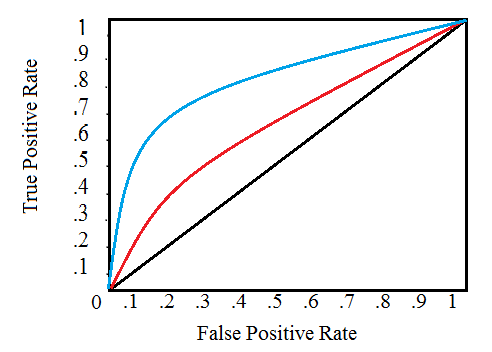

A single line on the top graph indicates the curve for a single model, and movement along a line indicates changing the threshold used for classifying a positive instance. The threshold starts at 0 in the upper right to and goes to 1 in the lower left. A curve that is to left and above another curve indicates a better model. For example, the blue model i better than the red model, which is better than the black diagonal line which indicates a better model. For example, the blue model is better than the red model, which is better than the black diagonal line which indicates a naive random guessing model.

The Area under the curve(AUC) explains itself by its name. It is simply the area under the ROC curve. (This is the integral of the curve.) This metric is between 0 and 1 with a better model scoring higher. A model that simply guesses at random will have an ROC AUC of 0.5.

When we measure a classifier according to the ROC AUC, we do not generation 0 or 1 predictions, but rather a probability between 0 and 1. This may be confusing because we usually like to think in terms of accuracy, but when we get into problems with inbalanced classes (we will se this is the case), accuracy is not the best metric. For example, if I wanted to build a model that could detect terrorists with 99.999% accuracy, I would simply make a model that predicted every single person was not a terrorist. Clearly, this wolud not be effective (the recall would be zero) and we use more advanced metrics such as ROC AUC or the F1 score to more accurately reflect the performance of a classifier. A model with a high ROC AUC will also have a high accuracy, but the ROC AUC is a better representation of model performance.



### Imports

We are using a typical data science stack: numpy, pandas, sklearn, matplotlib.

In [ ]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd

# sklearn prepocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# file system management
import os

# suppress warnings
import warnings
warnings.filterwarnings('ignore')
# ignore warnings, update, changing etx

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

### Read in Data

First, we can list all the available data files. There are a total of 9 lines: 1 main file for training (with target) 1 main file for testing (without the target), 1 example submission file, and 6 other files containing additional information about each loan.

In [ ]:
# list files available
print(os.listdir('../input/home-credit-default-risk'))

In [ ]:
# training data
app_train = pd.read_csv('../input/home-credit-default-risk/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

The training has 307511 observations (each one a seperate loan) and 122 features (variables) including the TARGET (the label we want to predict).

In [ ]:
# Testing data features
app_test = pd.read_csv('../input/home-credit-default-risk/application_test.csv')
print('Testing data shape:', app_test.shape)
app_test.head()

The test set is considerably smaller and lacks a Target column.

### Exploratory Data Analysis

Exploratory Data Analysis(EDA) is an open-ended process where we calculate statistics and make figures to find trends, anomalies, patterns or relationships within the data. The goal of EDA is to learn what our data can tell us. It is generally starts out with a high level overview, then narrows in to specific areas as we find intriguing areas of the data. The findings may be interesting in their own right, or they can be used to inform our modeling choices, such as by helping us decide which features to use.

### Examine the Distribution of the Target Column

The target is what we are asked to predict: either a 0 for the loan was reparied on time, or a 1 indicating the client had payment difficulties. We can first examine the number of loans falling into each category.

In [ ]:
app_train['TARGET'].value_counts()

In [ ]:
app_train['TARGET'].astype(int).plot.hist() ;

From this information, we see this is an [imbalanced class problem](http://www.chioka.in/class-imbalance-problem/). There are far more loans that were repaid on time than loans that were not repaid. Once we get into more sophisticated machine learning models, we can weight the classes by their representation in the data to reflect this imbalance.

### Examine Missing Values

Next we can look at the number and percentage of missing values in each column.

In [ ]:
# Function to calculate missing values by column
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()
    
    # percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns= {0: 'Missing Values', 1 : '% of Total Values'})
    
    # sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    
    # print some summary information
    print('Your selected dataframe has ' + str(df.shape[1]) +
         " columns.\n"
         "There are " + str(mis_val_table_ren_columns.shape[0]) +
         " columns that have missing values.")
    
    # return the dataframe with missing in information
    return mis_val_table_ren_columns

In [ ]:
# missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(20)

When it comes time to build our machine learning models, we will have to fill in these missing values (known as imputation). In later work, we will use models such as XGBoost that can handle missing values with no need for imputation. Another option would be to drop columns with a high percentage of missing values, although it is impossible to know ahead of time if these columns will be helpful to our model. Therefore, we will keep all of the columns for now.

### Column Types

let's look at the number of columns of each data type. *inf64* and *float64* are numerica variables (which can be either discrete or continuous). *object* columns contatin strings and are categorical features.

In [ ]:
# number of each type of column
app_train.dtypes.value_counts()

Let's now look at the number of unique entries in each of the *object* (categorical) columns.

In [ ]:
# number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

1. 데이터에 고유값이 무엇이 있는지 알고 싶다면 unique 

2. 총 고유값의 수가 몇 개인지 알고 싶다면 nunique 
(default) 결측값 하나의 값으로 미확인 >> dropna=True

3. 값별로 데이터의 개수를 알고 싶다면 value_counts
https://mizykk.tistory.com/103

Most of the categorical variables have a relatively small number of unique entries. We will need to find a way to deal with these categorical variables.

### Encoding Categorical Variables

Befor we go any further, we need to deal with pesky categorical variables. A machine learning model unfortunately cannot deal with categorical variables (except for some models such as LightGBM). Therefore, we have to find a way to encode (represent) these variables as numbers before handing them off to the model. There are two main ways to carry out this process.

* Label encoding: assign each unique category in a categorical variable with an interger. No new columns are created. 

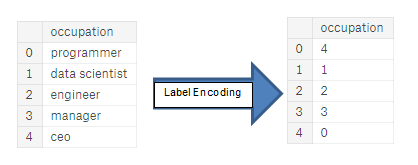

* One-hot encoding: create a new column for each unique category in a categorical variable. Each observation recieves a 1 in the column for its corresponding category and a 0 in all other new columns.

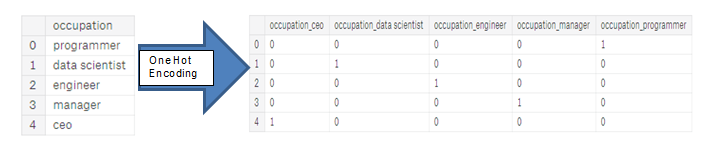

The problem with label encoding is that it gives the categories an arbitrary ordering. The value assigned to each of the categories in random and does not reflect any inherent aspect of the category. In the example above, programmer recieves a 4 adn data scientist a 1, but if we did the same process again, the labels could be reversed or completely different. The acutal assignment of the integers is arbitrary. Therefore, when we perform label encoding, the model might use the relative value of the feature (for example preogrammer = 4 and data scientist = 1) to assign weights which is not what we want. if we only have two unque values for a categorical varibales (As Male/Female), then label encoding is fine, but for more than 2 unique categories, one-hot encoding is the safe option.

There is some debate about the relative merits of these approaches, and some models can deal with label encoded categorical varibales with no issues. I think for categorical variables with many classes, one-hot encoding is the safest approach because it does not impose arbitrary values to categories. The only downside to one-hot encoding is that the numer of features can explode with categorical variables with many categories. To deal with this, we can perform one-hot-encoding followed with PCA or other dimensionality reduction methods to reduce the number of dimensions.

In this notebook, we will use Label Encoding for any categorical variables with only 2 categories and One-Hot Encoding for any categorical variables with more than 2 categories. This process may need to change as we get further into the project, but for now, we will see where this gets us.

### Label Encoding and One-Hoe Encoding

Let's implement the policy described above: for any categorical variable (dtype == object) with 2 unique categories, we will use label encoding, and for any categorical variable with more than 2 unique  categories, we will use one-hot encoding.

For label encoding, we use the scikit-learn labelencoder and for one-hot encoding, the pandas get_dummies(df) function

In [ ]:
# create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # if 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # train on the training data
            le.fit(app_train[col])
            # transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            
            # keep track of how many columns were label encoded
            le_count += 1

print('%d columns were label encoded.' % le_count)

In [ ]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Training Features shape: ', app_test.shape)

### Aligning Training and Testing Data

There need to be the same features (columns) in both the training and testing data. One-hot encoding has created more columns in the training data because there were some categorical variables with categories not represented in the testing data. To remove the columns in the training data that are not in the testing data, we need to align the dataframes. First we extract the target column from the training data (Because this is not in the testing data but we need to keep this information). When we do the align, we must make sure to set *axis = 1* to align the dataframes based on the columns and not on the rows.

In [ ]:
train_labels = app_train['TARGET']

# algin the training  and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis=1)

# add the target back in
app_train['TARGET'] = train_labels

print('training features shape: ', app_train.shape)
print('testing features shape: ', app_test.shape)

The training and testing datasets now have the same features which is required for machine learning. The number of features has grown significantly due to one-hot encoding. At some point we probably will want to try dimensionality reduction to reduce the size of the datasets.

### Back to Exploratory Data Analysis

#### Anomalies : **[explain url](https://wkdtjsgur100.github.io/anomaly/)**

One problem we always want to be on the lookout for when doing EDA is anomalies within the data. These may be due to mis-typed numbers, errors in measuring equipment, or they could be valid but extreme measurements. One way to support anomalies quantitatively is by looking at the statistics of a column using the describe method. **The numbers in the DAYS_BIRTH column are negative because they are recorded relative to the current loan application. To see these stats in years, we can multiple by -1 and divide by the number of days in a year:**

In [ ]:
(app_train['DAYS_BIRTH'] / -365).describe()

Those ages look reasonable. There are no outliers for the age on either the high or low end. How about the days of employment?

In [ ]:
app_train['DAYS_EMPLOYED'].describe()

That doesn't look right. The maximum value is about 1000 years.

In [ ]:
app_train['DAYS_EMPLOYED'].plot.hist(title='Days Employment Histogram');
plt.xlabel('Days employment');

Just out of curiosity, let's subset the anomalous clients and see if they tend to have higher or low rates of default than the rest of the clients.

In [ ]:
anom = app_train[app_train["DAYS_EMPLOYED"] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 362543]

print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom["TARGET"].mean()))
print('There are %d anoamlous days of employment' % len(anom))

This is extremly interesting. It turns out that the anomalies have a lower rate of default.

Handling the anomalies depends on the exact situation, with no set rules. One of the safest approaches is just to set the anomalies to a missing value and then have them filled in before machine learning. In this case, since all the anomalies have the exact same value, we want to fill them in with the same value in case all of these loans share something in common. The anomalous values seem to have some importance, so we want to tell the machie learning model if we did in fact fill in these values. As a solution, we will fill in the anomalous values with not a number (np.nan) and then create a new boolean column indicating whether or not the value was anomalous.

In [ ]:
# Create an anomalous flag column
app_train["DAYS_EMPLOYED_ANOM"] = app_train['DAYS_EMPLOYED'] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243:np.nan}, inplace=True)

app_train['DAYS_EMPLOYED'].plot.hist(title='Days employment histogram');
plt.xlabel('Days employment');

The distribution looks to be much more in line with what we would expect, and we also have created a new column to tell the model that these values were originally anomalous (because we will have to fill in the nans with some value, probably the median of the column). The other columns with *DAYS* in the dataframe look to be about what we expect with no obvious outliers.

As an extremely important note, anythin we do to the training data we also have to do to the testing data. Let's make sure to create the new column and fill in the existing column with *np.nan* in the testing data.

In [ ]:
app_test["DAYS_EMPLOYED_ANOM"] = app_test['DAYS_EMPLOYED'] == 365243
app_test['DAYS_EMPLOYED'].replace({365243:np.nan}, inplace=True)

print('There are %d anomalies in the test data out of %d entries' % (app_test['DAYS_EMPLOYED_ANOM'].sum(), len(app_test)))

### Correlations

Now that we have dealt with the categorical variables and the outliers, let's continue with the EDA. One way to try and understand the data is by lookinf for correlations between the features and the target. We can calculate the Pearson correlation coefficient between every variable and the target using the *.corr* dataframe method.

The correlation coefficient is not the greatest method to represent 'relevance' of a feature, but it does give us an idea of possible relationships within the data. Some general interpretations of the absolute value of the correlation coefficient are:

* 00~19: very weak
* 20-39: weak
* 40-59: moderate
* 60-79: strong
* 80-100: very strong

In [ ]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

In [ ]:
# display correlations
print('Most positive correlaionsa: \n', correlations.tail(15))
print('\nMost Negative correlations: \n', correlations.head(15))

Let's take a look a some of more significant correlations: the *DAYS_BIRTH* is the most positive correlations. Looking at the documentaion, *DAYS_BIRTH* is the age in days of the client at the time of the loan in negative days (for whatever reason). The correlation is positive, but the value of this feature is actually negative, meaning that as the client gets older, they are less likely to default on their laon (ie the target == 0). That's a little confusing, so we will take the absolute value of the feature and the the correlation will be negative.

### Effect of Age on Repayment

In [ ]:
# Find the correlation of the positive days since birth and target

app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

As the client gets older, there is a negative linear relationship with the target meaning that as clients get older, they tend to repay their loans on time more often.

Let's start looking at this varialbe. First, we can make a histogram of the age. We will put the x axis in years to make the plot a little more understandable.

In [ ]:
# set the style of plots
plt.style.use('fivethirtyeight')

# plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins=25)
plt.title('Age of client');
plt.xlabel('Age (years)');
plt.ylabel('count');

By itself, the distribution of age does not tell us much other than that there are no outliiers as all the ages are reasonable. To visualize the effect of the age on the target, we will next make a[ kernel density estimation plot](https://seongkyun.github.io/study/2019/02/03/KDE/) colored by the value ot the target. A kernel density estimate plot shows the distribution of a single variable and can be thought of as a smoothed histogram (it is created by computing a kernel, usually a Gaussian, at each data point and then averaging all the individual kernels to develop a single smooth curve). We will use the seaborn *kdeplot* for this graph.

In [ ]:
plt.figure(figsize=(10, 6))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH']/ 365, label= 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH']/ 365, label= 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)');
plt.ylabel('Density');
plt.legend();
plt.title('Distribution of Ages');

The 'targe == 1' curve skews toward the younger end of the ragne. Although this is not a significant correlation (-0.07 correlation coefficient), this variable is likely going to be useful in a machine learning model because it does affect the target. Let's look at this relationship in another way: average failure to repay loans by age bracket.

To make this graph, first we *cut* the age category into bins of 5 years each. Then, for each bin, we calculate the average value of the target, which tells us the ratio of loans that were not repaid in each age category.

In [ ]:
# age information into a seperate dataframe
age_data = app_train[['TARGET', "DAYS_BIRTH"]]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH']/365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins=np.linspace(20, 70, num=11))
age_data.head(10)

In [ ]:
# Group by the bin and calculate averages
age_groups = age_data.groupby('YEARS_BINNED').mean()
age_groups

In [ ]:
plt.figure(figsize=(10, 8))

# graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100*age_groups['TARGET'])

# plot labeling
plt.xticks(rotation = 75);
plt.xlabel('Age group (years)');
plt.ylabel('Failure to repay (%)');
plt.title('Failure to repay by age group');

There is a clear trend: 
younger applicants are more likely to not repay the loan!
The rate of failure to reapy is above 10% for the youngest three age groups and below 5% for the oldest age group.

This is information that could be directly used by the bank:
because younger clients are less likely to repay the loan, maybe they should be provided with more guidance or financial planning tips. This does not mean the bank should discriminate younger clients, but it would be smart to take precautionary measures to help younger clients pay on time.

### Exterior Sources

The 3 variables with the strongest negative correlations wtih the target are *ext_source_1*, *ext_source_2*, and *ext_source_3*. According to the documentation, these features represents a 'normalized score from external data source'. I'm not sure with this exactly means, but it may be a cumulative sort of credit rating made using numerous sources of data.

Let's take a look at these variables.

First, we can show the correlations of the *ext_source* features with the target and with each other.

In [ ]:
# Extract the EXT_SOURCE and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', "EXT_SOURCE_2", 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

In [ ]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot=True, vmax = 0.6)
plt.title('correlation heatmap');

All three EXT_SOURCE features have negative correlations with the target, indicating that as the value of the EXT_SOURCE increases, the client is more likely to repay the loan. We can also see that DAYS_BIRTH is positively correlated with EXP_SOURCE_1 indicating that maybe one of the factors in this score is the client age.

Next we can look at the distribution of each of these features colored by the value of the target. This will let us visulatize the effect of this variable on the target.

In [ ]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    # create a new subplot for each source
    plt.subplot(3, 1, i+1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repai
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # label the plots
    plt.title('distribution of %s by the target value' % source)
    plt.legend();
    plt.xlabel('%s' % source);
    plt.ylabel('Density');

plt.tight_layout(h_pad = 2.5)

EXT_SOURCE_3 displays the greatest difference between the values of the target. We can clearly see that this feature has some relationship to the likelihood of an applicant to repay a loan. The relationship is not very strong, in fact they are all considered very weak, but these variables will still be useful for a machine learning model to predict whether or not an applicant will repay a loan on time.

### Pairs Plot

As a final exploratroy plot, we can make a pairs plot of the EXT_SOURCE vaiables and the DAYS_BIRTH variable. The pairs Plot is a great exploration tool because it lets us see relationships between multiple pairs of variables as well as distributions of single variables. Here we are using the seaborn visualization library and the PairGrid function to create a Pairs Plot with scatterplots on the upper triangle, histograms on the diagonal, and 2D kernel density plots and correlation coefficients on the lower triangle.

In [ ]:
# Copy the data for plotting
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, size = 3, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

In this plot, the red indicates loans that were not repaid and the blue are loans that are paid. We can see the different relationships within the data. There does appear to be a moderate positive linear relationship between the EXT_SOURCE_1 and the DAYS_BIRTH (or equivalently YEARS_BIRTH), indicating that this feature may take into account the age of the client.

### Feature Engineering

Kaggle competitions are won by feature engineering: those win are those who can create the most useful features of the data. (This is true for the most part as the winning models, at least for structured data, all tend to be variants on gradient boosting). This represents one of the patterns in machine learning: feature engineering has a greater return on investment than model building and hyperparameter tuning. As Andrew NG is fond of saying: 'applied machine learning is basically feature engineering.'

While choosing the right model and optimal settings are important, the model can only learn from the data it is given. Making sure this data is as relevant to the task as possible is the jov of the data scientis (and maybe some automated tools to help us out).

Feature engineering refers to a geneal process and can involve both feature construction: adding new features from the existing data, and feature selection: choosing only the most important features or other methods of dimensionality reduction. There are many techniques we can use to both create features and select features.

We will do a lot of feature engineering when we start using the other data sources, but in this notebook we will try only two simple feature construction methods:
* Ploynomial features
* Domain knowledge features

### Polynomial Features

One simple feature construction method is called polynomial features. In this method, we make features that are powers of existing features as well as interaction terms between existing features. For example, we can creative variables EXT_SOURCE_1 x EXT_SOURCE_2, EXT_SOURCE_1 x EXT_SOURCE_2^2, EXT_SOURCE_1^2 x EXT_SOURCE_2^2, and so on. These features that are a combination of multiple individual variables are called interaction terms because they capture the interactions between variables. In other words, while two variables by themselves may not have a strong influence on the target, combining them together into a single interaction variable might show a relationship with the target. Interaction terms are commonly used in statistical models to capture the effects of multiple variables, but I do not see them usesd as often in machine learning. Nonetheless, we can try out a few to see if they might help our model to predict whether or not a client will repay a loan.

Jake VanderPlas writes about polynomial features in his excellent book python for Data science for those who want more information.

In the following code, we create polynomiial features using the EXT_SOURCE variables and the DAYS_BIRTH variable. Scikit-learn has a useful class called PolynomialFeatures that creates the polynomials and the interaction terms up to a specified degree. We can use a degree of 3 to see the results (when we are creating polynomial features, we want to avoid using too high of a degree, both because the number of features scales exponentially with the degree, and because we can run into probles with overfitting).

In [ ]:
# make a new dataframe for polynomial features

poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.fit_transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures

# create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [ ]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)

print('polynomial features shpae', poly_features.shape);

This creates a considerable number of new features. To get the names we have to use the polynomial features get_feature_names method.

In [ ]:
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

There are 35 features with individual features raised to powers up to degree 3 and interaction terms. Now, we can see whether any of these new features are correlated with the target.

In [ ]:
# create a dataframe of the features
poly_features = pd.DataFrame(poly_features,
                            columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# add in the target
poly_features['TARGET'] = poly_target

# find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# display most negative and most positive
print(poly_corrs.head(10));
print(poly_corrs.tail(5));

Several of new variables have a greater (in terms of absolute magnitude) correlation with the target than the original features. When we build machine learning models, we can try with and without these features to determine if they actually help the model learn.

We will add these features to a copy of the training and testing data and than evaluate models with and without the features. Many times in machine learning, the only way to know if an approach will work is to try it out!

In [ ]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test,
                                 columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'EXT_SOURCE_4']))

# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polnomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test_poly = app_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, 
                                                    join = 'inner', axis =1)
# print out the new shape
print('training data with polynomial features shape', app_train_poly.shape);
print('testing data with polynomial features shape', app_test_poly.shape);

### Domain Knowledge Features

Maybe It's not entirely correct to call this 'domain knowledge' because i'm not a credit expert, but perhaps we could call this 'attempts at applying limited financial knowledge'. In this frame of mind, we can make a couple features that attempt to capture what we think may be important for telling whether a client will default on a loan. Here I'm going to use five features that were inspired by this script by Agular:

* CREDIT_INCOME_PERCENT: the percentage of the credit amount relative to a client's income

* ANNUITY_INCOME_PERCENT: the percentage of the loan annuity relative to a client's income

* CREDIT_TERM: the length of the payment in months (since the annuity is the monthly amount due

* DAYS_EMPLOYED_PERCENT: the percentage of the days employed relative to the client's age

In [ ]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [ ]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

### Visualize new Variables

We should explore these **domain knowledge** variables visually in a graph. For all of these, we will make the same KDE plot colored by the value of the TARGET.

In [ ]:
plt.figure(figsize = (12, 20))
# iterate through the new features

for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 
                             'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    # create a new subplot for each source
    plt.subplot(4, 1, i+1)

    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature],
               label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature],
               label = 'target == 1')
    
    # label the plots
    plt.title('distribution of %s by the target value' % feature)
    plt.xlabel('%s' % feature);
    plt.ylabel('density');
    plt.legend();

plt.tight_layout(h_pad = 2.5)

### Baseline

For a naive baseline, we could guess the same value ofr all examples on the testing set. We are asked to predict the probability of not repaying the loan, so if we are entirely unsure, we would guess 0.5 for all observations on the test set. This will get us a Receiver Operating Characteristic Area Under the Curve (AUC ROC) of 0.5 in the competition (random quessing on a classification task will score a 0.5).

Since we already know what score we are going to get, we don't really need to make a naive baseline guess. Let's use a slightly more sophisticated model for our actual baseline: Logistic Regression.

### Logistic Regression Implementation

Here I will focus on implementing the model rather than explaining the details, but for those who want to learn more about the theory of machine learning algorithms, I recommend both An Introduction to Statistical learning and Hands-on machine learning with scikit-learn and tensorflow. Both of these book present the theory and alo code needed to make the modlels. They both teach with the mindset that the best way to learn is by doing, and they are very effective.

To get a baseline, we will use all of the features after encoding the categorical variables. We will preprocess the data by filling in the missing values (imputation) adn normalizing the range of the features (feature scaling). The following code performs both of these preprocssing steps.

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# drop the target from the training data 
if 'TARGET' in app_train:
    train = app_train.drop(columns = ['TARGET'])
else:
    train = app_train.copy()
    
# Feature names
features = list(train.columns)

# copy of the testing data
test = app_test.copy()

# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')

# scale each feature to 0-1
scaler = MinMaxScaler(feature_range= (0, 1))

# Fit on the training date
imputer.fit(train)

# transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(app_test)

# repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('training data shape', train.shape)
print('testing data shape', test.shape)

We will use LogisticRregression from scikit-learn for our first model.
The only change we will make from the default model settings is to lower the regularization parameter, C, which controls the amount of overfitting (a lower value should decrease overfitting). This will get us slightly better results than the default LogisticRegression, but it still will set a low bar for any future models.

Here we use the familiar scikit-learn modeling syntax: we first create the model, then we train the model using .fit and then we make predictions on the testing data using .predict_proba.

In [ ]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

# Train on the training data
log_reg.fit(train, train_labels)

Now that the model has been trained, we can use it to make predictions. We want to predict the probabilities of not paying a loan, so we use the model predict.proba method. This returns an m x 2 array where m is the number of observations. The first column is the probability of the target being 0 and the second column is the probability of the target being 1 (so for a single row, the two columns must sum to 1). We want the probability the loan is not repaid, so we will select the second column.

The following code makes the predictions and selects the correct column.

In [ ]:
# make predictions
# make sure to select the second column only
log_reg_pred = log_reg.predict_proba(test)[:, 1]

The predictions must be in the format shown in the sample_submission.csv file, where there are only two columns: SK_ID_CURR and TARGET. We will create a dataframe in this format from the test set and the predictions called submit

In [ ]:
# submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred

submit.head()

In [ ]:
# save the submission to a csv file
submit.to_csv('log_reg_baseline.csv', index=False)

The submission has now been saved to the virtual environment in which our notebook is running. To access the submission, at the end of the notebook, we will hit the blue Commit & Run button at the upper right of the kernel. This runs the entire notebook and then lets us download any files that are created during the run.

Once we run the notebook, the files created are available in the Versions tab under the Output sub-tab. From here, the submission files can be submitted to the competition or downloaded. Since there are several models in this notebook, there will be multiple output files.

**The logistic regression baseline should score around 0.671 when submitted.**

### Improved Model: random forest

To try and beat the poor performance of our baseline, we can update the algorithm. Let's try using a Random Forest on the same training data to see how that affects performance. The Random Forest is a much more powerful model especially when we use hundreds of trees. We will use 100 trees in the random forest.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# make the random foreset classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=50,
                                      verbose =1, n_jobs= -1)

In [ ]:
# train on the training data
random_forest.fit(train, train_labels)

# extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 
                                    'importance': feature_importance_values})

# make predictions on the test data
predictions = random_forest.predict_proba(test)[:, 1]

In [ ]:
# make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# save the submission dataframe
submit.to_csv('random_forest_baseline.csv', index=False)

These predictinos will also be available when we run the entire notebook.

**This model should score around 0.678 when submitted.**

### Make Predictions using Engineered Features

This only way to see if the Polynomial Features and Domain knowledge improved the model is to train a test a model on these features! We can then compare the submission performance to that for the model without these features to gauge the effect of our feature engineering.

In [ ]:
poly_features_names = list(app_train_poly.columns)

# impute the polynomial features
imputer = SimpleImputer(strategy = 'median')

poly_features = imputer.fit_transform(app_train_poly)
poly_features_test = imputer.transform(app_test_poly)

# scale the polynomial features
scaler = MinMaxScaler(feature_range= (0,1))

poly_features = scaler.fit_transform(poly_features)
poly_features_test = scaler.transform(poly_features_test)

random_forest_poly = RandomForestClassifier(n_estimators= 100,
                                           random_state=50, verbose = 1, n_jobs= -1)

In [ ]:
# train pn the training data 
random_forest_poly.fit(poly_features, train_labels)

# make predictions on the test data
predictions = random_forest_poly.predict_proba(poly_features_test)[:, 1]

In [ ]:
# make a submission dataframe
submit = app_test['SK_ID_CURR']
submit['TARGET'] = predictions

# save the submission dataframe
submit.to_csv('random_forest_baseline_engineered.csv', index=False)

This model scored 0.678 when submitted to the competition, exactly the same as that without the enigneered features. Given these results, it does not appear that our feature construction helped in this case.

### Testing domain features

Now we can test the domain features we made by hand.

In [ ]:
app_train_domain = app_train_domain.drop(columns = 'TARGET')

domain_features_names = list(app_train_domain.columns)

# Impute the domainnomial features
imputer = SimpleImputer(strategy = 'median')

domain_features = imputer.fit_transform(app_train_domain)
domain_features_test = imputer.transform(app_test_domain)

# Scale the domainnomial features
scaler = MinMaxScaler(feature_range = (0, 1))

domain_features = scaler.fit_transform(domain_features)
domain_features_test = scaler.transform(domain_features_test)

random_forest_domain = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

# Train on the training data
random_forest_domain.fit(domain_features, train_labels)

# Extract feature importances
feature_importance_values_domain = random_forest_domain.feature_importances_
feature_importances_domain = pd.DataFrame({'feature': domain_features_names, 'importance': feature_importance_values_domain})

# Make predictions on the test data
predictions = random_forest_domain.predict_proba(domain_features_test)[:, 1]

In [ ]:
# make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# save the submission dataframe
submit.to_csv('random_forest_baseline_domain.csv', index=False)

This scores a 0.679 when submitted which probably shows that the engineered features do not help in this model (however they do help in the Gradient Boosting model at the end of the notebook).

In later notebooks, we will do more feature engineering by using the information from the other data sources. From experience, this will definitely help our model.

### Model Interpretation: Feature Importances

As a simple method to see which variables are the most relevant, we can look at the feature importances of the random forest. Given the correlations we saw in the exploratory data analysis, we should expect that the most important features are the EXT_SOURCE and the DAYS_BIRTH. We may use these feature importances as a method of dimensionality reduction in future work.

In [ ]:
def plot_feature_importances(df):
    
    # sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    
    # make a horizontal bar chartt of feature importance
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # need to reverse the index to plot most importance on top
    ax.barh(list(reversed(list(df.index[:15]))),
           df['importance_normalized'].head(15),
           align = 'center', edgecolor = 'k')
    
    # set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # plot labeling
    plt.xlabel('normalized importance');
    plt.title('feature importances');
    plt.show()
    
    return df

In [ ]:
# show the feature importance for the default features
feature_importances_sorted = plot_feature_importances(feature_importances)

As expected, the most important features are those dealing with EXT_SOURCE and DAYS_BIRTH. We see that there are only a handful of features with a significant importance to the model, which suggests we may be able to drop many of the features without a decrease in performance (and we may even see an increase in performance.) Feature importances are not the most sophisticated method to interpret a model or perform dimensionality reduction, but they let us start to understand what factors our model takes into account when it makes predictions.

In [ ]:
feature_importances_domain_sorted = plot_feature_importances(feature_importances_domain)

We see that all four of our hand-engineered features made it into the top 15 most important! This should give us confidence that our domain knowledge was at least partially on track.

## Conclusions

In this notebook, we saw how to get started with a Kaggle machine learning competition. We first made sure to understand the data, our task, and the metric by which our submissions will be judged. Then, we performed a fairly simple EDA to try and identify relationships, trends, or anomalies that may help our modeling. Along the way, we performed necessary preprocessing steps such as encoding categorical variables, imputing missing values, and scaling features to a range. Then, we constructed new features out of the existing data to see if doing so could help our model.

Once the data exploration, data preparation, and feature engineering was complete, we implemented a baseline model upon which we hope to improve. Then we built a second slightly more complicated model to beat our first score. We also carried out an experiment to determine the effect of adding the engineering variables.

We followed the general outline of a machine learning project:

1. Understand the problem and the data
2. Data cleaning and formatting (this was mostly done for us)
3. Exploratory Data Analysis
4. Baseline model
5. Improved model
6. Model interpretation (just a little)

Machine learning competitions do differ slightly from typical data science problems in that we are concerned only with achieving the best performance on a single metric and do not care about the interpretation. However, by attempting to understand how our models make decisions, we can try to improve them or examine the mistakes in order to correct the errors. In future notebooks we will look at incorporating more sources of data, building more complex models (by following the code of others), and improving our scores.

I hope this notebook was able to get you up and running in this machine learning competition and that you are now ready to go out on your own - with help from the community - and start working on some great problems!

**Running the notebook**: now that we are at the end of the notebook, you can hit the blue Commit & Run button to execute all the code at once. After the run is complete (this should take about 10 minutes), you can then access the files that were created by going to the versions tab and then the output sub-tab. The submission files can be directly submitted to the competition from this tab or they can be downloaded to a local machine and saved. The final part is to share the share the notebook: go to the settings tab and change the visibility to Public. This allows the entire world to see your work!